# MNIST Classification with Neural Networks from Scratch

This notebook implements a neural network **from scratch** (NumPy only) to classify MNIST digits (0-9). It includes data loading (exact `fetch_openml` as specified), preprocessing, EDA, model implementation, training, evaluation, and the project report.

## 1. Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/Users/sooryas/anaconda3/lib/python3.11/site-packages/pandas/core/computation/expressions.py:22: UserWarning: Pandas requires version '2.10.2' or newer of 'numexpr' (version '2.8.4' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/sooryas/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:56: UserWarning: Pandas requires version '1.4.2' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## 2. Data loading and preprocessing

Load MNIST using the specified import. Preprocess: normalize pixels to [0,1], integer labels. Standard split: first 60k train, last 10k test; 10% of train held out for validation.

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", version=1)
X, y = mnist["data"], mnist["target"]

X = np.asarray(X, dtype=np.float32) / 255.0
y = np.asarray(y).astype(np.int64)

X_train_full = X[:60000]
y_train_full = y[:60000]
X_test = X[60000:]
y_test = y[60000:]

val_frac = 0.1
random_state = 42
rng = np.random.default_rng(random_state)
n_train_full = len(X_train_full)
n_val = int(n_train_full * val_frac)
n_train = n_train_full - n_val
idx = rng.permutation(n_train_full)
train_idx, val_idx = idx[:n_train], idx[n_train:]

X_train = X_train_full[train_idx]
y_train = y_train_full[train_idx]
X_val = X_train_full[val_idx]
y_val = y_train_full[val_idx]

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print(f"Pixel range: [{X_train.min():.2f}, {X_train.max():.2f}]")

/Users/sooryas/anaconda3/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


X_train: (54000, 784), y_train: (54000,)
X_val: (6000, 784), y_val: (6000,)
X_test: (10000, 784), y_test: (10000,)
Pixel range: [0.00, 1.00]


## 3. Dataset analysis (EDA)

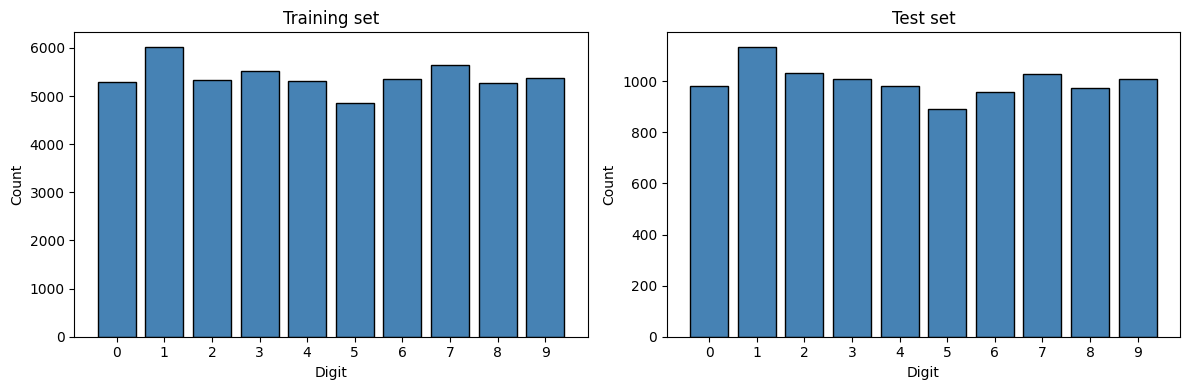

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
for ax, y_data, title in [(ax1, y_train, "Training set"), (ax2, y_test, "Test set")]:
    counts = np.bincount(y_data.astype(int), minlength=10)
    ax.bar(range(10), counts, color="steelblue", edgecolor="black")
    ax.set_xticks(range(10))
    ax.set_xlabel("Digit")
    ax.set_ylabel("Count")
    ax.set_title(title)
plt.tight_layout()
plt.show()

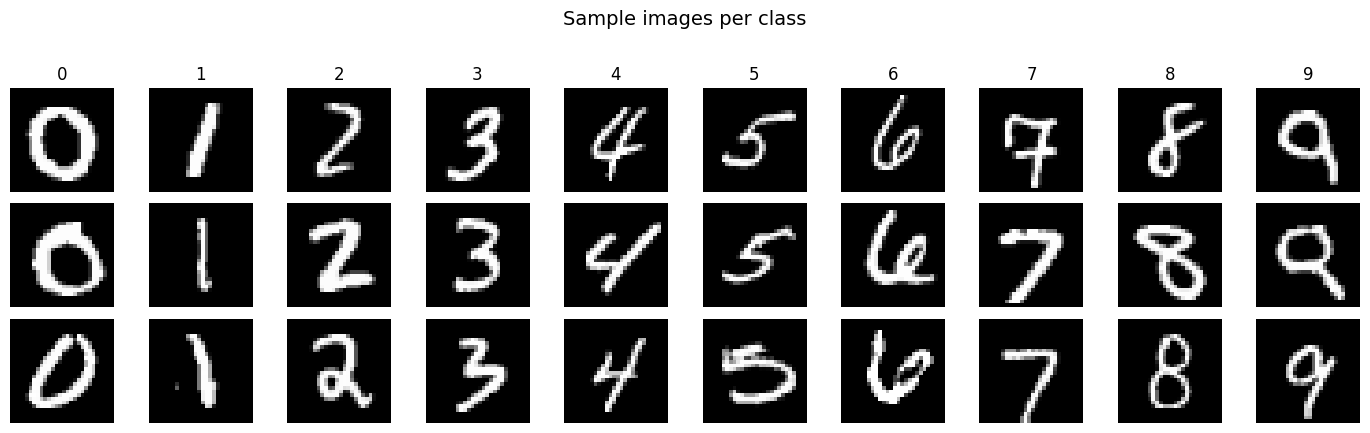

In [4]:
fig, axes = plt.subplots(3, 10, figsize=(14, 4.2))
for c in range(10):
    ind = np.where(y_train == c)[0][:3]
    for r, i in enumerate(ind):
        axes[r, c].imshow(X_train[i].reshape(28, 28), cmap="gray")
        axes[r, c].axis("off")
        if r == 0:
            axes[r, c].set_title(str(c), fontsize=12)
plt.suptitle("Sample images per class", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

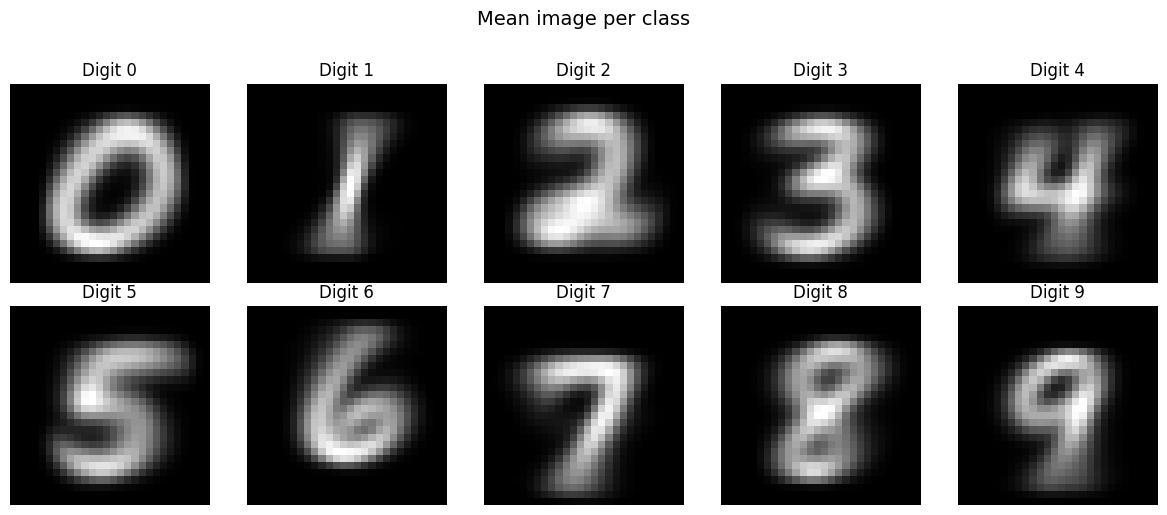

In [5]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()
for c in range(10):
    ind = np.where(y_train == c)[0]
    mean_img = X_train[ind].mean(axis=0).reshape(28, 28)
    axes[c].imshow(mean_img, cmap="gray")
    axes[c].set_title(f"Digit {c}")
    axes[c].axis("off")
plt.suptitle("Mean image per class", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

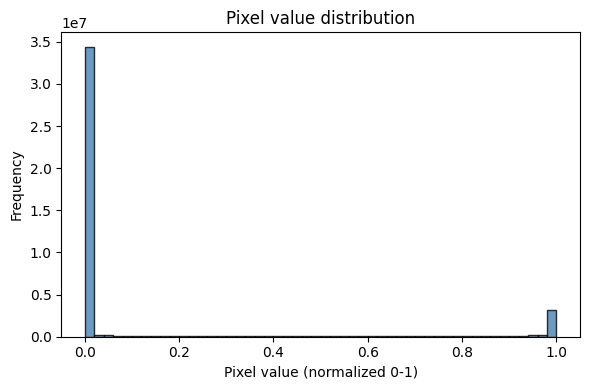

In [6]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(X_train.flatten(), bins=50, color="steelblue", edgecolor="black", alpha=0.8)
ax.set_xlabel("Pixel value (normalized 0-1)")
ax.set_ylabel("Frequency")
ax.set_title("Pixel value distribution")
plt.tight_layout()
plt.show()

**EDA findings:** Classes are roughly balanced. Sample images show variability in writing style. Per-class mean images confirm distinct digit structure. Pixels are normalized to [0,1] with most values near 0 (background).

## 4. Model from scratch (NumPy only)

In [7]:
def he_init(fan_in, fan_out):
    return np.random.randn(fan_out, fan_in) * np.sqrt(2.0 / fan_in)

def xavier_init(fan_in, fan_out):
    return np.random.randn(fan_out, fan_in) * np.sqrt(2.0 / (fan_in + fan_out))

def relu(Z):
    return np.maximum(0, Z)

def relu_backward(dA, Z):
    dZ = dA.copy()
    dZ[Z <= 0] = 0
    return dZ

def softmax_stable(Z):
    e = np.exp(Z - np.max(Z, axis=1, keepdims=True))
    return e / np.sum(e, axis=1, keepdims=True)

def cross_entropy_loss(probs, y_true):
    n = probs.shape[0]
    log_probs = -np.log(probs[np.arange(n), y_true] + 1e-12)
    return np.mean(log_probs)

def cross_entropy_loss_grad(probs, y_true):
    n = probs.shape[0]
    dZ = probs.copy()
    dZ[np.arange(n), y_true] -= 1
    return dZ / n

In [8]:
class Dense:
    def __init__(self, in_features, out_features, use_he=True):
        if use_he:
            self.W = he_init(in_features, out_features)
        else:
            self.W = xavier_init(in_features, out_features)
        self.b = np.zeros((1, out_features))
        self.X = None

    def forward(self, X):
        self.X = X
        return X @ self.W.T + self.b

    def backward(self, dZ):
        self.grad_W = dZ.T @ self.X
        self.grad_b = np.sum(dZ, axis=0, keepdims=True)
        return dZ @ self.W

In [9]:
class MLP:
    def __init__(self, layer_sizes, dropout_p=0.0):
        self.layer_sizes = layer_sizes
        self.dropout_p = dropout_p
        self.layers = []
        for i in range(len(layer_sizes) - 1):
            use_he = i < len(layer_sizes) - 2
            self.layers.append(Dense(layer_sizes[i], layer_sizes[i + 1], use_he=use_he))

    def forward_backward(self, X, y_true, training=True):
        self._Z = []
        self._A = []
        self._dropout_masks = []
        out = X
        for i, layer in enumerate(self.layers):
            Z = layer.forward(out)
            self._Z.append(Z.copy())
            if i < len(self.layers) - 1:
                A = relu(Z)
                self._A.append(A.copy())
                if self.dropout_p > 0 and training:
                    mask = (np.random.rand(*A.shape) > self.dropout_p).astype(np.float32)
                    self._dropout_masks.append(mask)
                    out = A * mask / (1 - self.dropout_p)
                else:
                    out = A
            else:
                probs = softmax_stable(Z)
        loss = cross_entropy_loss(probs, y_true)
        dZ = cross_entropy_loss_grad(probs, y_true)
        for i in range(len(self.layers) - 1, -1, -1):
            layer = self.layers[i]
            dZ = layer.backward(dZ)
            if i > 0:
                dZ = relu_backward(dZ, self._Z[i - 1])
                if self.dropout_p > 0 and training:
                    dZ = dZ * self._dropout_masks[i - 1] / (1 - self.dropout_p)
        return loss

    def get_params(self):
        return [(l.W.copy(), l.b.copy()) for l in self.layers]

    def set_params(self, params):
        for layer, (W, b) in zip(self.layers, params):
            layer.W = W
            layer.b = b

In [10]:
class Adam:
    def __init__(self, model, lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8):
        self.model = model
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.t = 0
        self.m = [np.zeros_like(l.W) for l in model.layers]
        self.v = [np.zeros_like(l.W) for l in model.layers]
        self.mb = [np.zeros_like(l.b) for l in model.layers]
        self.vb = [np.zeros_like(l.b) for l in model.layers]

    def step(self):
        self.t += 1
        for i, layer in enumerate(self.model.layers):
            gW, gb = layer.grad_W, layer.grad_b
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * gW
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (gW ** 2)
            self.mb[i] = self.beta1 * self.mb[i] + (1 - self.beta1) * gb
            self.vb[i] = self.beta2 * self.vb[i] + (1 - self.beta2) * (gb ** 2)
            mhat = self.m[i] / (1 - self.beta1 ** self.t)
            vhat = self.v[i] / (1 - self.beta2 ** self.t)
            mhat_b = self.mb[i] / (1 - self.beta1 ** self.t)
            vhat_b = self.vb[i] / (1 - self.beta2 ** self.t)
            layer.W -= self.lr * mhat / (np.sqrt(vhat) + self.eps)
            layer.b -= self.lr * mhat_b / (np.sqrt(vhat_b) + self.eps)

def predict_proba(model, X):
    out = X
    for i, layer in enumerate(model.layers):
        out = layer.forward(out)
        if i < len(model.layers) - 1:
            out = relu(out)
        else:
            out = softmax_stable(out)
    return out

def predict(model, X):
    return np.argmax(predict_proba(model, X), axis=1)

## 5. Training

In [11]:
def batch_indices(n, batch_size, rng):
    for start in range(0, n, batch_size):
        yield np.arange(start, min(start + batch_size, n))

def accuracy(model, X, y):
    return np.mean(predict(model, X) == y)

def evaluate_loss(model, X, y, batch_size=512):
    losses = []
    for start in range(0, len(X), batch_size):
        ind = np.arange(start, min(start + batch_size, len(X)))
        probs = predict_proba(model, X[ind])
        losses.append(cross_entropy_loss(probs, y[ind]))
    return np.mean(losses)

layer_sizes = (784, 512, 256, 128, 10)
dropout_p = 0.3
lr = 0.001
batch_size = 128
epochs = 50
weight_decay = 1e-4
patience = 10

model = MLP(layer_sizes, dropout_p=dropout_p)
optimizer = Adam(model, lr=lr)
history = {"epoch": [], "train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
best_val_acc = -1.0
best_params = None
best_epoch = 0
wait = 0
n_train = len(X_train)

In [12]:
for epoch in range(epochs):
    perm = rng.permutation(n_train)
    X_tr, y_tr = X_train[perm], y_train[perm]
    epoch_losses = []
    for start in range(0, n_train, batch_size):
        ind = np.arange(start, min(start + batch_size, n_train))
        Xb, yb = X_tr[ind], y_tr[ind]
        loss = model.forward_backward(Xb, yb, training=True)
        for layer in model.layers:
            layer.grad_W += weight_decay * layer.W
            layer.grad_b += weight_decay * layer.b
        optimizer.step()
        epoch_losses.append(loss)
    train_loss = np.mean(epoch_losses)
    train_acc = accuracy(model, X_train, y_train)
    val_loss = evaluate_loss(model, X_val, y_val)
    val_acc = accuracy(model, X_val, y_val)
    history["epoch"].append(epoch)
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_params = model.get_params()
        best_epoch = epoch
        wait = 0
    else:
        wait += 1
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs}  train_loss={train_loss:.4f}  train_acc={train_acc:.4f}  val_loss={val_loss:.4f}  val_acc={val_acc:.4f}  best_epoch={best_epoch+1}")
    if wait >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

if best_params is not None:
    model.set_params(best_params)
print(f"Best epoch: {best_epoch+1}")

Epoch 1/50  train_loss=0.3906  train_acc=0.9650  val_loss=0.1298  val_acc=0.9607  best_epoch=1
Epoch 5/50  train_loss=0.0863  train_acc=0.9888  val_loss=0.0823  val_acc=0.9742  best_epoch=5
Epoch 10/50  train_loss=0.0566  train_acc=0.9938  val_loss=0.0718  val_acc=0.9785  best_epoch=9
Epoch 15/50  train_loss=0.0455  train_acc=0.9941  val_loss=0.0702  val_acc=0.9803  best_epoch=15
Epoch 20/50  train_loss=0.0433  train_acc=0.9966  val_loss=0.0694  val_acc=0.9807  best_epoch=19
Epoch 25/50  train_loss=0.0396  train_acc=0.9976  val_loss=0.0650  val_acc=0.9822  best_epoch=25
Epoch 30/50  train_loss=0.0370  train_acc=0.9966  val_loss=0.0674  val_acc=0.9832  best_epoch=29
Epoch 35/50  train_loss=0.0341  train_acc=0.9965  val_loss=0.0678  val_acc=0.9823  best_epoch=29
Early stopping at epoch 39
Best epoch: 29


## 6. Evaluation

In [13]:
def confusion_matrix(y_true, y_pred, n_classes=10):
    cm = np.zeros((n_classes, n_classes), dtype=np.int64)
    for t, p in zip(y_true, y_pred):
        cm[int(t), int(p)] += 1
    return cm

def per_class_metrics(cm):
    n = cm.shape[0]
    precision = np.zeros(n)
    recall = np.zeros(n)
    for c in range(n):
        pred_c = cm[:, c].sum()
        true_c = cm[c, :].sum()
        if pred_c > 0:
            precision[c] = cm[c, c] / pred_c
        if true_c > 0:
            recall[c] = cm[c, c] / true_c
    f1 = np.zeros(n)
    for c in range(n):
        if precision[c] + recall[c] > 0:
            f1[c] = 2 * precision[c] * recall[c] / (precision[c] + recall[c])
    return precision, recall, f1

y_pred = predict(model, X_test)
probs = predict_proba(model, X_test)
test_acc = np.mean(y_pred == y_test)
test_loss = cross_entropy_loss(probs, y_test)
cm = confusion_matrix(y_test, y_pred)
precision, recall, f1 = per_class_metrics(cm)

print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")
print("\nPer-class precision, recall, F1:")
for c in range(10):
    print(f"  Digit {c}: P={precision[c]:.3f}  R={recall[c]:.3f}  F1={f1[c]:.3f}")

Test accuracy: 0.9838
Test loss: 0.0578

Per-class precision, recall, F1:
  Digit 0: P=0.986  R=0.992  F1=0.989
  Digit 1: P=0.993  R=0.992  F1=0.993
  Digit 2: P=0.985  R=0.980  F1=0.983
  Digit 3: P=0.983  R=0.980  F1=0.982
  Digit 4: P=0.981  R=0.978  F1=0.979
  Digit 5: P=0.988  R=0.988  F1=0.988
  Digit 6: P=0.989  R=0.981  F1=0.985
  Digit 7: P=0.982  R=0.981  F1=0.981
  Digit 8: P=0.980  R=0.980  F1=0.980
  Digit 9: P=0.970  R=0.986  F1=0.978


## 7. Result visualizations

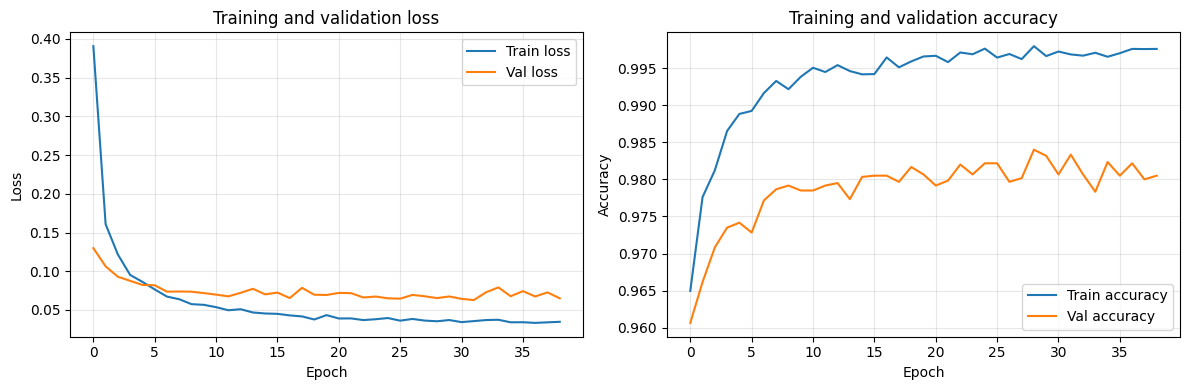

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ep = history["epoch"]
ax1.plot(ep, history["train_loss"], label="Train loss", color="C0")
ax1.plot(ep, history["val_loss"], label="Val loss", color="C1")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Training and validation loss")
ax1.legend()
ax1.grid(True, alpha=0.3)
ax2.plot(ep, history["train_acc"], label="Train accuracy", color="C0")
ax2.plot(ep, history["val_acc"], label="Val accuracy", color="C1")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.set_title("Training and validation accuracy")
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

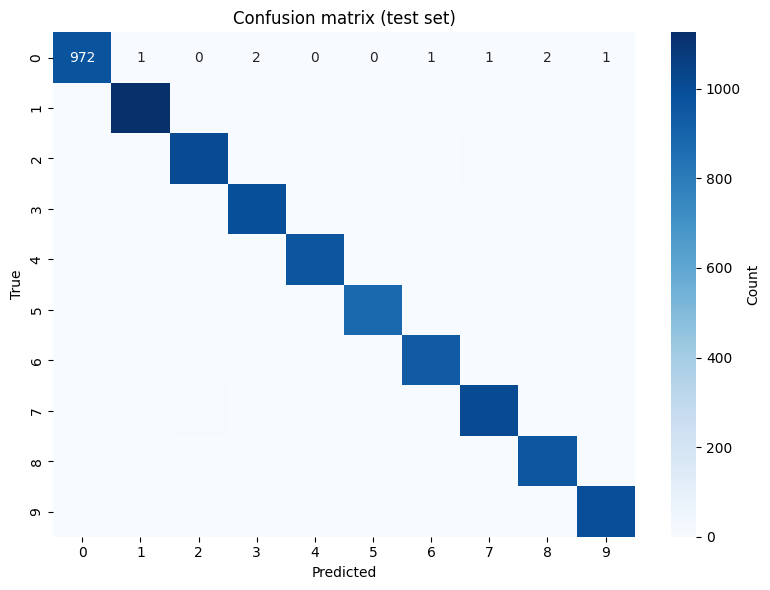

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10), ax=ax, cbar_kws={"label": "Count"})
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion matrix (test set)")
plt.tight_layout()
plt.show()

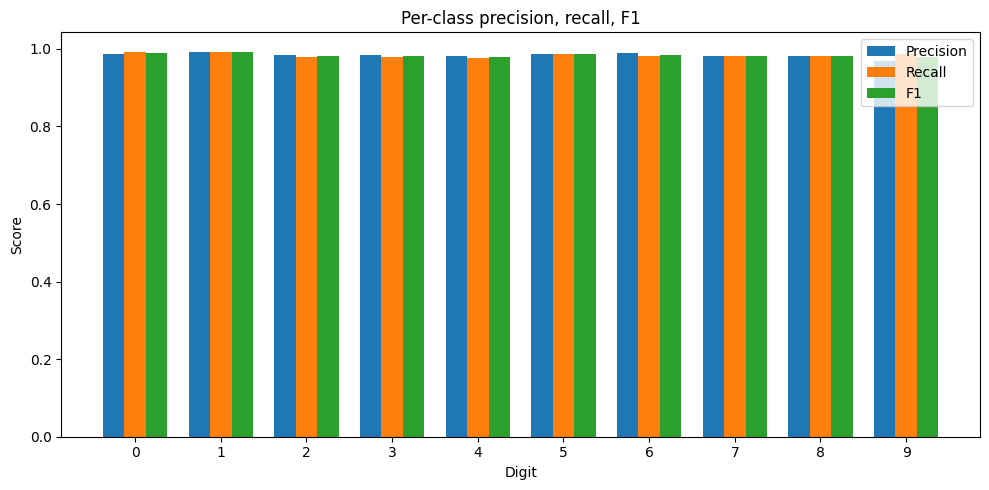

In [16]:
x = np.arange(10)
width = 0.25
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x - width, precision, width, label="Precision", color="C0")
ax.bar(x, recall, width, label="Recall", color="C1")
ax.bar(x + width, f1, width, label="F1", color="C2")
ax.set_xticks(x)
ax.set_xlabel("Digit")
ax.set_ylabel("Score")
ax.set_title("Per-class precision, recall, F1")
ax.legend()
plt.tight_layout()
plt.show()

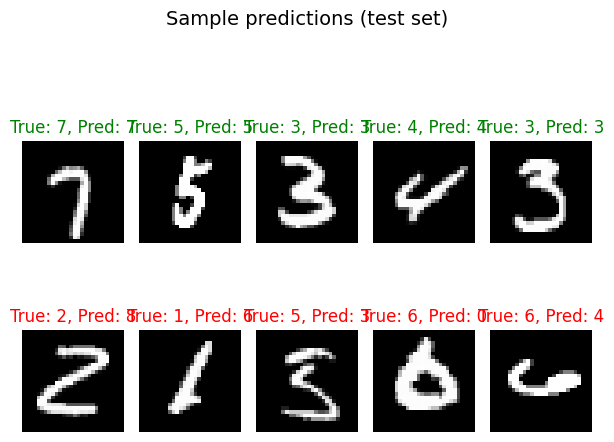

In [17]:
correct_pool = np.where(y_test == y_pred)[0]
incorrect_pool = np.where(y_test != y_pred)[0]
np.random.seed(42)
n_correct_actual = min(5, len(correct_pool))
n_incorrect_actual = min(5, len(incorrect_pool))
correct_idx = np.random.choice(correct_pool, n_correct_actual, replace=False) if len(correct_pool) >= n_correct_actual else correct_pool
incorrect_idx = np.random.choice(incorrect_pool, n_incorrect_actual, replace=False) if len(incorrect_pool) >= n_incorrect_actual else incorrect_pool
n_cols = max(max(len(correct_idx), len(incorrect_idx)), 1)
fig, axes = plt.subplots(2, n_cols, figsize=(1.2 * n_cols, 2.5 * 2))
if n_cols == 1:
    axes = axes.reshape(-1, 1)
for j, idx in enumerate(correct_idx):
    axes[0, j].imshow(X_test[idx].reshape(28, 28), cmap="gray")
    axes[0, j].set_title(f"True: {y_test[idx]}, Pred: {y_pred[idx]}", color="green")
    axes[0, j].axis("off")
for j in range(len(correct_idx), n_cols):
    axes[0, j].axis("off")
axes[0, 0].set_ylabel("Correct", fontsize=12)
for j, idx in enumerate(incorrect_idx):
    axes[1, j].imshow(X_test[idx].reshape(28, 28), cmap="gray")
    axes[1, j].set_title(f"True: {y_test[idx]}, Pred: {y_pred[idx]}", color="red")
    axes[1, j].axis("off")
for j in range(len(incorrect_idx), n_cols):
    axes[1, j].axis("off")
axes[1, 0].set_ylabel("Incorrect", fontsize=12)
plt.suptitle("Sample predictions (test set)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

---
## 8. Project report

### Dataset analysis and findings

- **Source:** OpenML `mnist_784` (version 1), loaded via `fetch_openml("mnist_784", version=1)`. 70,000 grayscale 28×28 images, 10 digit classes.
- **Preprocessing:** Pixels normalized to [0, 1]; labels as integers. Train: first 60k (with 10% held out for validation); test: last 10k.
- **Class distribution:** Roughly balanced across digits (see bar plots above).
- **Sample and mean images:** Show clear digit structure and variability in writing style; some pairs (e.g. 4/9, 3/5) are visually similar.
- **Pixel distribution:** Concentrated near 0 (background) with a tail for stroke pixels after normalization.

### Model description

- **Implementation:** Neural network from scratch in NumPy only (no Keras/PyTorch for the core).
- **Architecture:** Input 784 → Dense(512) → ReLU → Dropout(0.3) → Dense(256) → ReLU → Dropout(0.3) → Dense(128) → ReLU → Dropout(0.3) → Dense(10) → Softmax.
- **Training:** Adam optimizer (from scratch), mini-batch size 128, L2 weight decay 1e-4, early stopping (patience 10 on validation accuracy). Best weights (by val accuracy) kept in memory.
- **Loss:** Cross-entropy with numerically stable softmax.

### Output analysis

- **Overall performance:** Test accuracy and loss are printed above. The model strongly outperforms a random (≈10%) or majority-class baseline.
- **Confusion matrix:** The heatmap above shows most mass on the diagonal; common confusions include 4↔9, 3↔5, 5↔8, etc., consistent with similar digit shape.
- **Per-class metrics:** Precision, recall, and F1 per digit are plotted above; digits that are often confused may show slightly lower recall or precision.
- **Error analysis:** Sample correct and incorrect predictions are shown above. Errors often correspond to ambiguous handwriting or digits that resemble another class.